In [1]:
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [2]:
#para leer un archivo Yaml en Python
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

In [3]:
#importamos los dataframes
df_final_demo = pd.read_csv(config['data']['demo_final'], sep=",", header=0,low_memory=False)

pt_1 = pd.read_csv(config['data']['pt_1'], sep= ",", header=0, low_memory=False)

pt_2 = pd.read_csv(config['data']['pt_2'], sep= ",", header=0, low_memory=False)

df_exp = pd.read_csv(config['data']['exp_client'], sep=",", header=0,low_memory=False)

#concatenamos los dataframes pt_1 y pt_2
df_final_web_data = pd.concat([pt_1, pt_2], axis=0).reset_index(drop=True)

In [4]:
#empezamos a revisar todos los elementos del primer dataframe df_final_demo para realizar la limpieza
#vemos primeros resultados y nombres de columnas
df_final_demo.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


QUÉ SIGNIFICA CADA COLUMNA
clnt_tenure_yr = tiempo que lleva siendo cliente en años
clnt_tenure_mnth = tiempo que lleva siendo cliente en meses
clnt_age = edad
gendr = género
num_accts = número de cuentas que tiene el cliente
bal = saldo total que se reparte entre las dos cuentas del cliente
calls_6_mnth = veces que el cliente se comunicó a través de una llamada en los últimos 6 meses
logons_6_mnth = frecuencia con que el cliente ingresa en la plataforma los últimos 6 meses

In [5]:
#vemos cuántas filas y columnas tiene el dataframe
df_final_demo.shape

(70609, 9)

In [6]:
#vemos los tipos de datos asignados a cada columna
df_final_demo.dtypes

client_id             int64
clnt_tenure_yr      float64
clnt_tenure_mnth    float64
clnt_age            float64
gendr                object
num_accts           float64
bal                 float64
calls_6_mnth        float64
logons_6_mnth       float64
dtype: object

In [7]:
#miramos las columnas que son numéricas
df_final_demo.select_dtypes("number").columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')

In [8]:
#sacamos los valores únicos para las columnas con datos numéricos
df_final_demo.select_dtypes("number").nunique().sort_values(ascending=False)

client_id           70609
bal                 70328
clnt_tenure_mnth      482
clnt_age              165
clnt_tenure_yr         54
logons_6_mnth           9
num_accts               8
calls_6_mnth            8
dtype: int64

In [9]:
#vemos la columna con datos categóricos
df_final_demo.select_dtypes("object").columns

Index(['gendr'], dtype='object')

In [10]:
#comprobamos si hay valores nulos en todo el dataframe
df_final_demo.isnull().sum()

client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr               14
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
dtype: int64

In [11]:
#eliminamos la columna clnt_tenure_mnth
df_final_demo.drop("clnt_tenure_mnth", axis = 1, inplace = True)

In [12]:
#Cambiamos el nombre de las columnas para que sean más descriptivos
df_final_demo.columns = ["client_id","permanence_year","age","gender","num_accounts","total_balance","calls_months","login_month"]

In [13]:
#revisamos si se aplicaron los cambios
df_final_demo

,client_id,permanence_year,age,gender,num_accounts,total_balance,calls_months,login_month
0,836976,6.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...
70604,7993686,4.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,12.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,16.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,21.0,68.0,M,3.0,475114.69,4.0,4.0


In [14]:
#empezamos a revisar todos los elementos del segundo dataframe df_final_web_data para realizar la limpieza
#vemos las columnas y primeros resultados del dataframe
df_final_web_data.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [15]:
#vemos los tipos de data por defecto para cada columna
df_final_web_data.dtypes

client_id        int64
visitor_id      object
visit_id        object
process_step    object
date_time       object
dtype: object

In [16]:
#no hay valores nulos en ninguna columna y todos las columnas son de tipo objeto
df_final_web_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755405 entries, 0 to 755404
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   client_id     755405 non-null  int64 
 1   visitor_id    755405 non-null  object
 2   visit_id      755405 non-null  object
 3   process_step  755405 non-null  object
 4   date_time     755405 non-null  object
dtypes: int64(1), object(4)
memory usage: 28.8+ MB


In [17]:
#comprobamos el número de valores que tiene cada columna
df_final_web_data.nunique()

client_id       120157
visitor_id      130236
visit_id        158095
process_step         5
date_time       629363
dtype: int64

In [18]:
#confirmamos que no hay valores nulos
df_final_web_data.isnull().sum()

client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

In [19]:
#comprobamos los duplicados
df_final_web_data.duplicated().sum()

10764

In [20]:
#eliminamos los 10764 valores duplicados
df_final_web_data.drop_duplicates(keep='first', inplace=True)

In [21]:
#comprobamos cuántas filas se han eliminado
df_final_web_data.shape

(744641, 5)

In [22]:
#cambiamos el formato de la columna date_time
try:
    
    #cambiamos el formato de la columna 'date_time'.

    df_final_web_data["date_time"] = pd.to_datetime(df_final_web_data["date_time"], format='%Y-%m-%d %H:%M:%S')
    print("La columna date_time es de tipo datetime")
    
except ValueError:
        
    #Si la transformación da error el código arroja los valores problemáticos.

    print("Algunos valores en la columna no pudieron ser convertidos a date_time")
    print("Valores problemáticos:")
    problematic_values = df_final_web_data.loc[pd.to_datetime(df_final_web_data['date_time'], errors='coerce').isnull(), 'date_time']
    print(problematic_values)

La columna date_time es de tipo datetime


In [23]:
#comprobamos que, efectivamente, se ha modificado el tipo de datos para la columna data_type
df_final_web_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744641 entries, 0 to 755404
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     744641 non-null  int64         
 1   visitor_id    744641 non-null  object        
 2   visit_id      744641 non-null  object        
 3   process_step  744641 non-null  object        
 4   date_time     744641 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 34.1+ MB


In [24]:
#empezamos a revisar todos los elementos del tercer dataframe df_exp para realizar la limpieza
#visualizamos las columnas y primeros resultados
df_exp.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [25]:
#cambiamos el nombre de la columna Variation
df_exp = df_exp.rename(columns={'Variation': 'variation'})

In [26]:
#revisamos los tipos de data por defecto para cada columna
df_exp.dtypes

client_id     int64
variation    object
dtype: object

In [27]:
#revisamos si hay datos duplicados y vemos que no hay 
df_exp.duplicated().sum()

0

In [28]:
#revisamos si hay datos nulos 
df_exp.isnull().sum()

client_id        0
variation    20109
dtype: int64

In [29]:
#calculamos los principales clientes basados en el dinero total de sus cuentas
clientes_principales = df_final_demo.groupby('client_id')['total_balance'].sum().nlargest(50)

In [30]:
#filtramos el dataframe original solo para los clientes principales
df_clientes_principales = df_final_demo[df_final_demo['client_id'].isin(clientes_principales.index)]

In [31]:
#comprobamos cómo ha quedado el dataframe
df_clientes_principales.head()

,client_id,permanence_year,age,gender,num_accounts,total_balance,calls_months,login_month
2171,2291985,7.0,41.0,M,2.0,8247729.97,1.0,4.0
6406,4179430,9.0,66.5,M,2.0,4635079.65,6.0,9.0
7701,6076924,18.0,59.5,M,4.0,4024657.40,2.0,6.0
8508,9990452,27.0,35.5,M,3.0,4607206.68,5.0,8.0
10943,606032,14.0,66.0,M,3.0,4555876.35,6.0,9.0


In [35]:
#calculamos métricas estadísticas para las columnas tipo número
df_clientes_principales.select_dtypes("number").describe()

,client_id,permanence_year,age,num_accounts,total_balance,calls_months,login_month
count,5.000000e+01,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000
mean,5.407329e+06,17.980000,57.580000,3.000000,5.731276e+06,5.420000,7.780000
std,3.022354e+06,8.636633,10.704929,0.903508,2.292440e+06,1.371577,1.787599
min,1.296590e+05,4.000000,26.500000,2.000000,3.986272e+06,1.000000,2.000000
25%,2.452809e+06,11.000000,54.000000,2.000000,4.466770e+06,5.000000,7.000000
50%,6.008444e+06,17.500000,59.000000,3.000000,4.734690e+06,6.000000,9.000000
75%,8.004878e+06,24.000000,65.375000,3.000000,6.378546e+06,6.000000,9.000000
max,9.990452e+06,37.000000,74.500000,6.000000,1.632004e+07,7.000000,9.000000


In [36]:
#calculamos la media, la mediana y la moda del dinero en cuenta de los principales clientes
media_de_dinero = df_clientes_principales['total_balance'].mean()
mediana_de_dinero = df_clientes_principales['total_balance'].median()
moda_de_dinero = df_clientes_principales['total_balance'].mode()

media_de_dinero, mediana_de_dinero

(5731276.075200001, 4734689.994999999)

In [37]:
std_de_dinero = df_clientes_principales['total_balance'].std()
var_de_dinero = df_clientes_principales['total_balance'].var()
min_de_dinero = df_clientes_principales['total_balance'].min()
max_de_dinero = df_clientes_principales['total_balance'].max()

std_de_dinero, var_de_dinero, min_de_dinero, max_de_dinero

(2292440.3162921155, 5255282603761.495, 3986272.4, 16320040.15)

In [38]:
rango_de_dinero = max_de_dinero - min_de_dinero
quantiles_de_dinero = df_clientes_principales['total_balance'].quantile([0.25, 0.5, 0.75])

rango_de_dinero, quantiles_de_dinero

(12333767.75,
 0.25    4.466770e+06
 0.50    4.734690e+06
 0.75    6.378546e+06
 Name: total_balance, dtype: float64)

In [39]:
#agrupamos las edades por grupos de edad: jóvenes hasta 36, adultos jóvenes hasta 54 y adultos mayores a partir de 54.
bins = [18, 36, 54, df_clientes_principales['age'].max()]
labels = ['jóvenes', 'adultos jóvenes', 'adultos mayores']

#añadimos la columna 'age_grouped' con las edades agrupadas al dataframe de clientes principales
df_clientes_principales['age_grouped'] = pd.cut(df_clientes_principales['age'], bins=bins, labels=labels, include_lowest=True)

C:\Users\perez\AppData\Local\Temp\ipykernel_22132\273248205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clientes_principales['age_grouped'] = pd.cut(df_clientes_principales['age'], bins=bins, labels=labels, include_lowest=True)


c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


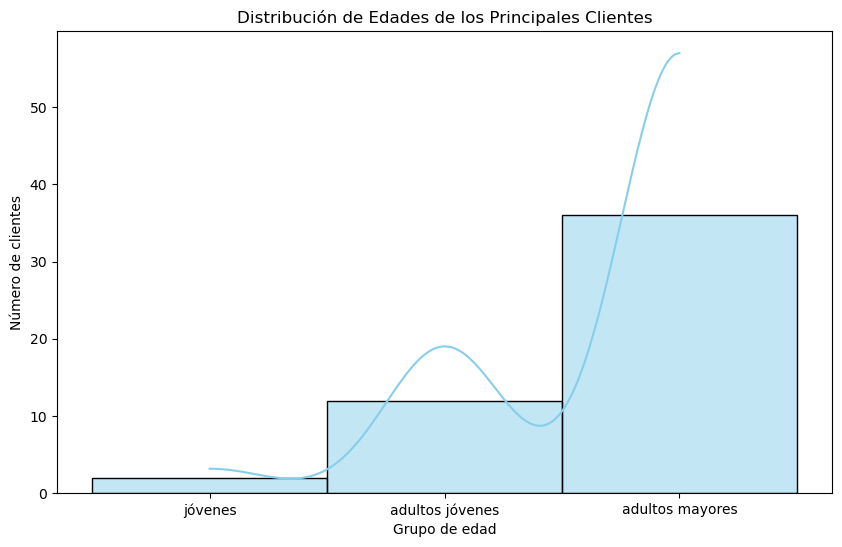

In [41]:
#creamos el histograma para observar la edad de los principales clientes
plt.figure(figsize=(10, 6))
sns.histplot(df_clientes_principales['age_grouped'], bins=20, kde=True, color='skyblue')
plt.title('Distribución de Edades de los Principales Clientes')
plt.xlabel('Grupo de edad')
plt.ylabel('Número de clientes')
plt.show()

In [32]:
#calculamos la frecuencia de cada uno de los géneros para los clientes principales
frecuencia_genero = df_clientes_principales['gender'].value_counts()
frecuencia_genero

gender
M    40
F     9
U     1
Name: count, dtype: int64

In [33]:
#calculamos la proporción de cada uno de los géneros
proporcion_genero = df_clientes_principales['gender'].value_counts(normalize=True)
proporcion_genero

gender
M    0.80
F    0.18
U    0.02
Name: proportion, dtype: float64

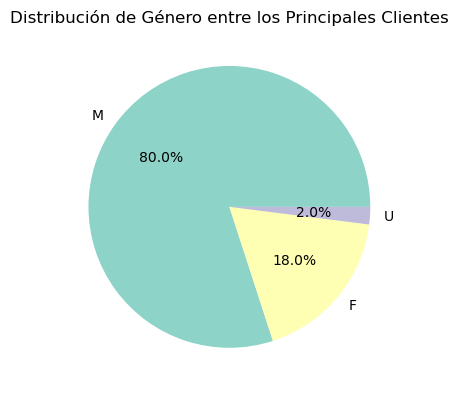

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

#creamos gráfico circular para mostrar la proporción de géneros entre los principales clientes
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer subgráfico
plt.pie(frecuencia_genero, labels=frecuencia_genero.index, autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Distribución de Género entre los Principales Clientes')
plt.show()

In [247]:
#agrupamos los años por grupos

bins = [0, 5, 15, df_clientes_principales['age'].max()]
labels = ['Clientes nuevos', 'Clientes consolidados', 'Clientes antiguos']
df_clientes_principales['permanence_year_grouped'] = pd.cut(df_clientes_principales['permanence_year'], bins=bins, labels=labels, include_lowest=True)

C:\Users\perez\AppData\Local\Temp\ipykernel_9300\3092257920.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



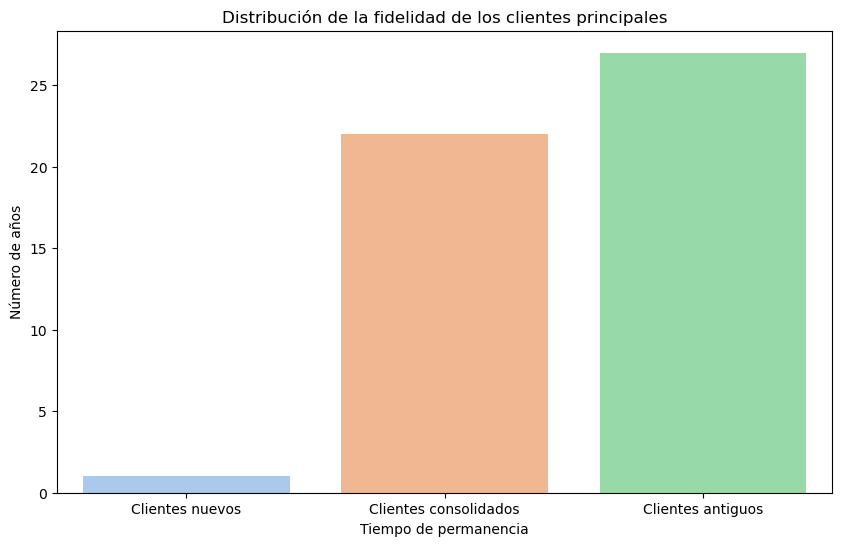

In [248]:
#Gráfico de barras de años que llevan como clientes los principales clientes
plt.figure(figsize=(10, 6))
sns.countplot(x='permanence_year_grouped', data=df_clientes_principales, palette='pastel')
plt.title('Distribución de la fidelidad de los clientes principales')
plt.xlabel('Tiempo de permanencia')
plt.ylabel('Número de años')
plt.show()

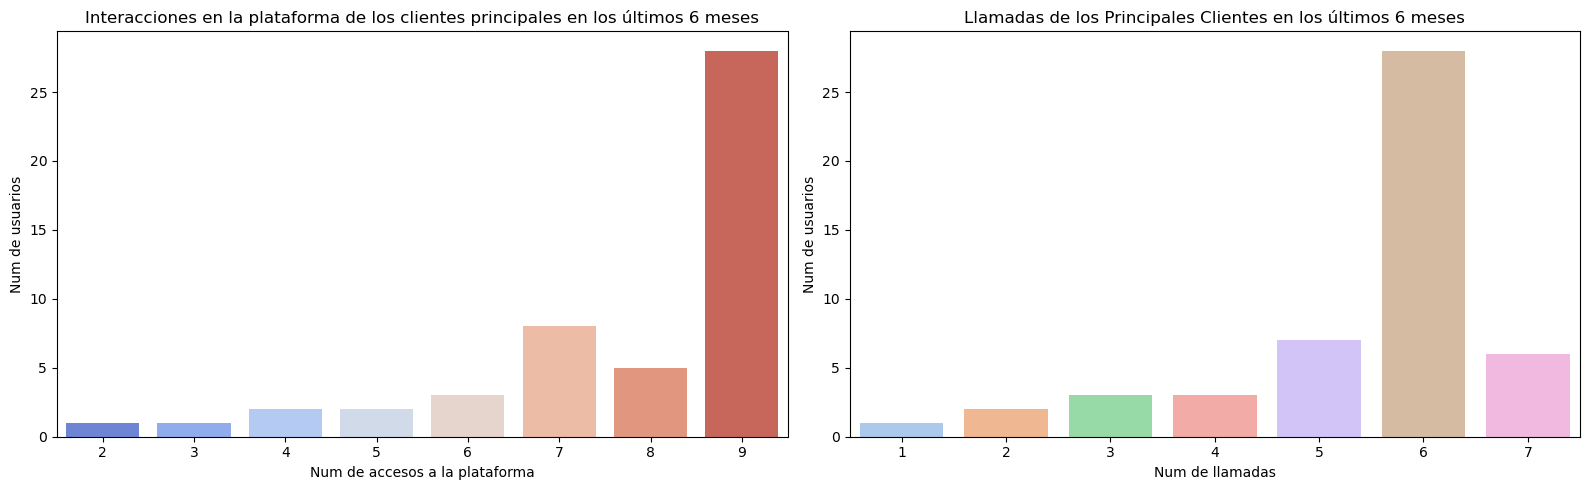

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una figura con dos subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Gráfico de barras de interacciones en la web en los últimos 6 meses de los principales clientes
sns.countplot(x='login_month', data=df_clientes_principales, palette='coolwarm', ax=axes[0])
axes[0].set_title('Interacciones en la plataforma de los clientes principales en los últimos 6 meses')
axes[0].set_xlabel('Num de accesos a la plataforma')
axes[0].set_ylabel('Num de usuarios')

# Gráfico de barras de clientes que hablaron en los últimos 6 meses de los principales clientes
sns.countplot(x='calls_months', data=df_clientes_principales, palette='pastel', ax=axes[1])
axes[1].set_title('Llamadas de los Principales Clientes en los últimos 6 meses')
axes[1].set_xlabel('Num de llamadas')
axes[1].set_ylabel('Num de usuarios')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico combinado
plt.show()

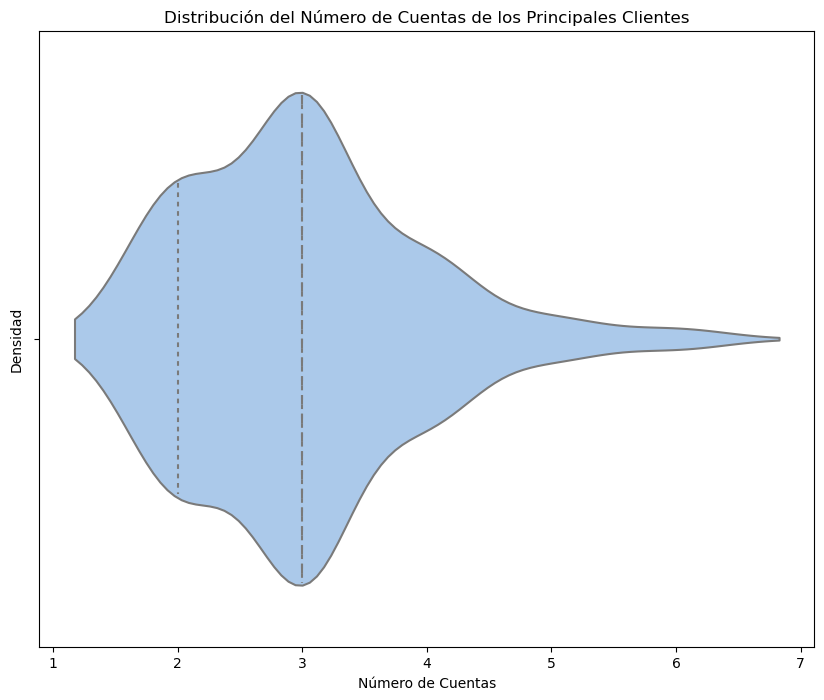

In [251]:
plt.figure(figsize=(10, 8))
sns.violinplot(x=df_clientes_principales['num_accounts'], inner='quartile', palette='pastel')
plt.title('Distribución del Número de Cuentas de los Principales Clientes')
plt.xlabel('Número de Cuentas')
plt.ylabel('Densidad')
plt.show()

¿Quiénes son los clientes principales?
¿Son los clientes principales jovenes o mayores, nuevos o clientes fieles?

La edad media de los clientes principales es de 58 años con una deviación estándar de tan solo 10, valor mínimo de 27 y máximo de 75.
Por lo que concluimos que la mayor parte de clientes principales tienen una edad avanzada.
En el gráfico de barras, podemos comprobar que, efectivamente, la mayor parte de los clientes principales tienen entre 50 y 70 años.

Los clientes principales son mayoritariamente hombres (80%), tan solo un 18% son mujeres y un 2% NS/NC.

Los clientes principales llevan siéndolo de media 18 años, así que suelen ser clientes fieles.
Aunque la desviación estándar es alta, de 9, y el valor mínimo de 4 y máximo de 37, por lo que también asumimos que hay mucha variación en este dato. El gráfico de barras nos ayuda a confirmar esta primera hipótesis.

La media de cuentas que tienen es de 3.
El mínimo de cuentas a su nombre son 2 y el máximo son 6, aunque la desviación estándar es menor a 1, por lo que asumimos que la mayor parte de clientes principales tienen alrededor de 3 cuentas.
En el gráfico de violín se ve claramente que la mayor parte de los clientes principales tiene 3 cuentas y, en menor, medida, 2.

El dinero de media en la cuenta para los clientes principales es de 5.731.276 dólares, mientras que la moda es 31.188 dólares.
El mínimo de dinero en cuenta es de 3.986.272 dólares y el máximo es de 16.320.040 dólares y la desviación estándar de 2.262.440 indican que hay mucha variación en el dinero en cuenta.
No obstante, el dinero en cuenta de los clientes principales es muy elevado.

La distribución del dinero en cuenta está sesgada a la derecha, por lo que hay elevado dinero (skewness de 2.8) y el valor de kurtosis por encima de 3 (9.8) indica la existencia de outliers.

En el gráfico de caja vemos que los que tienen mayor cantidad de dinero de media son los que tienen dos cuentas, seguidos de los de 3. Después de este gráfico, pensamos que debemos eliminar los outliers para dinero en cuenta y los que tienen 6 cuentas.

La mayor parte de clientes principales ha accedido 9 veces a la plataforma en los últimos 6 meses y la mayor parte de los clientes principales ha contactado con la empresa vía telefónica 6 veces. 


In [252]:
#calculamos la matriz de correlación para crear un mapa de calor que muestre la relación entre todas las variables

#convertimos variables categóricas en variables dummy
df_dummies = pd.get_dummies(df_clientes_principales)

#calculamos la matriz de correlación
matriz_de_correlacion_1 = df_dummies.corr()

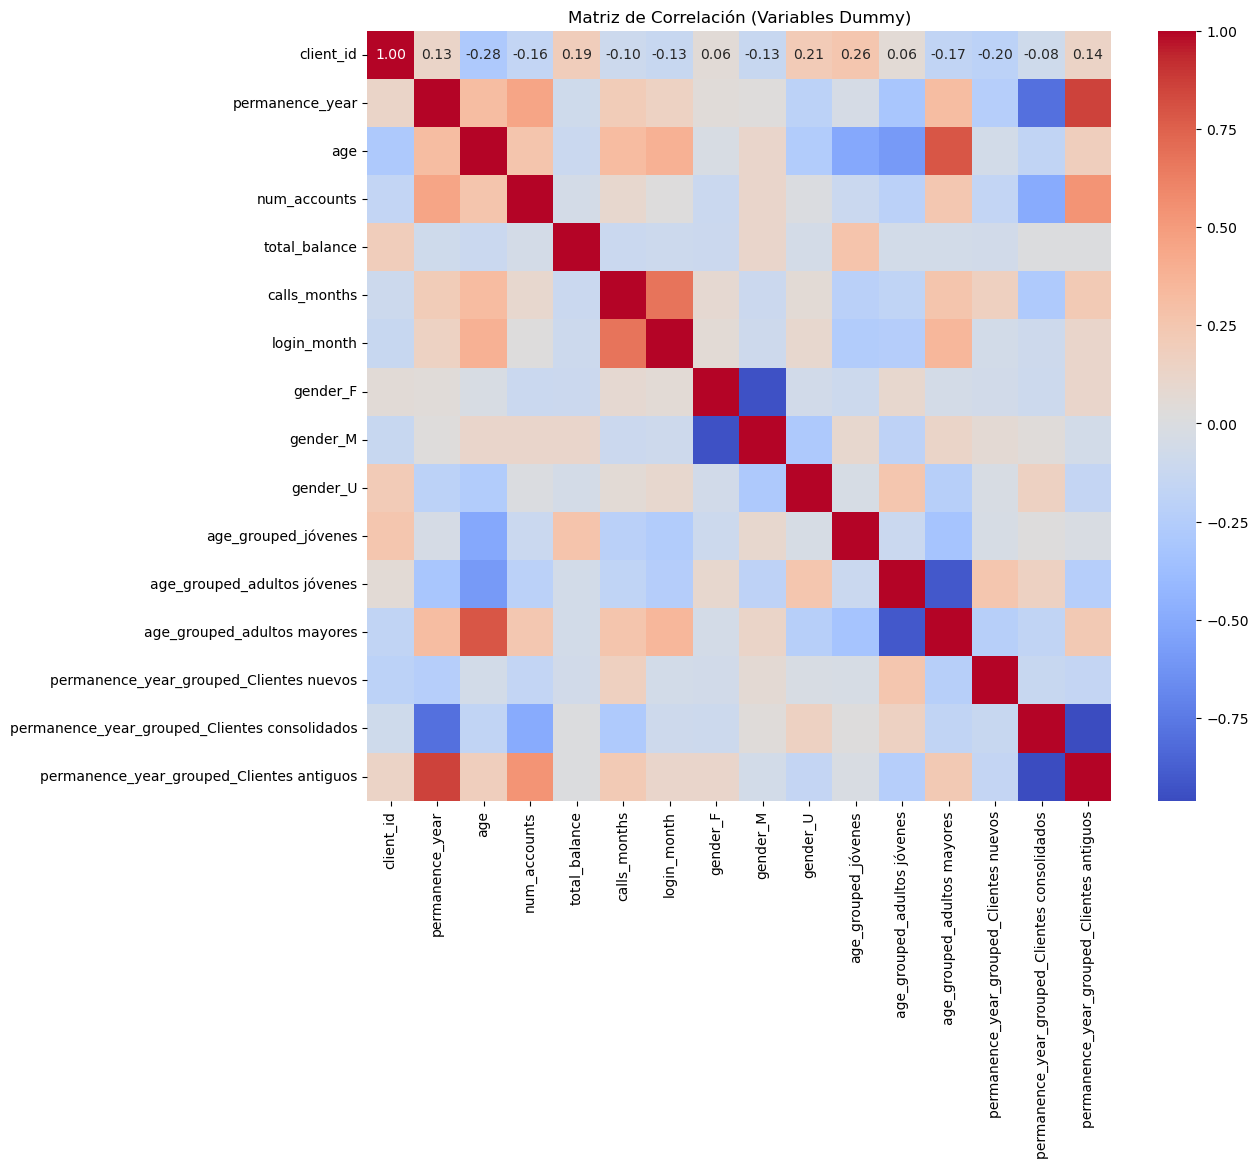

In [253]:
#creamos el heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(matriz_de_correlacion_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación (Variables Dummy)')
plt.show()

In [254]:
#calculamos la matriz de correlación para crear un mapa de calor que muestre la relación entre variables numéricas

matriz_de_correlacion = df_clientes_principales[['total_balance', 'age', 'num_accounts']].corr()

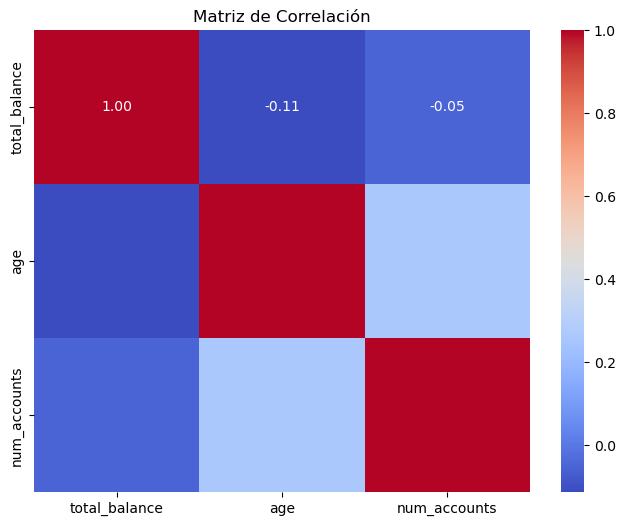

In [255]:
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_de_correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [256]:
#vemos que hay más relación entre el número de cuentas y el dinero en cuenta
#también hay cierta relación aunque menos entre la edad del cliente y el dinero en cuenta

In [257]:
#calculamos skewness y kurtosis para ver outliers del dinero en cuenta

skewness_dinero_en_cuenta = df_clientes_principales['total_balance'].skew()

kurtosis_dinero_en_cuenta = df_clientes_principales['total_balance'].kurtosis()

skewness_dinero_en_cuenta, kurtosis_dinero_en_cuenta

(2.7981877251024803, 9.757427336193642)

In [258]:
#eliminamos los outliers del dinero en cuenta

#calculamos el IQM

Q1 = df_clientes_principales['total_balance'].quantile(0.25)
Q3 = df_clientes_principales['total_balance'].quantile(0.75)
IQR = Q3 - Q1

#establecemos los límites de los outliers

limite_bajo = Q1 - 1.5 * IQR
limite_alto = Q3 + 1.5 * IQR

#identificamos los outliers y los filtramos de la tabla

df_clientes_principales = df_clientes_principales[(df_clientes_principales['total_balance'] >= limite_bajo) & (df_clientes_principales['total_balance'] <= limite_alto)]

#comprobamos que hemos eliminado 7 clientes principales al eliminar valores outliers
df_clientes_principales.shape


(48, 10)

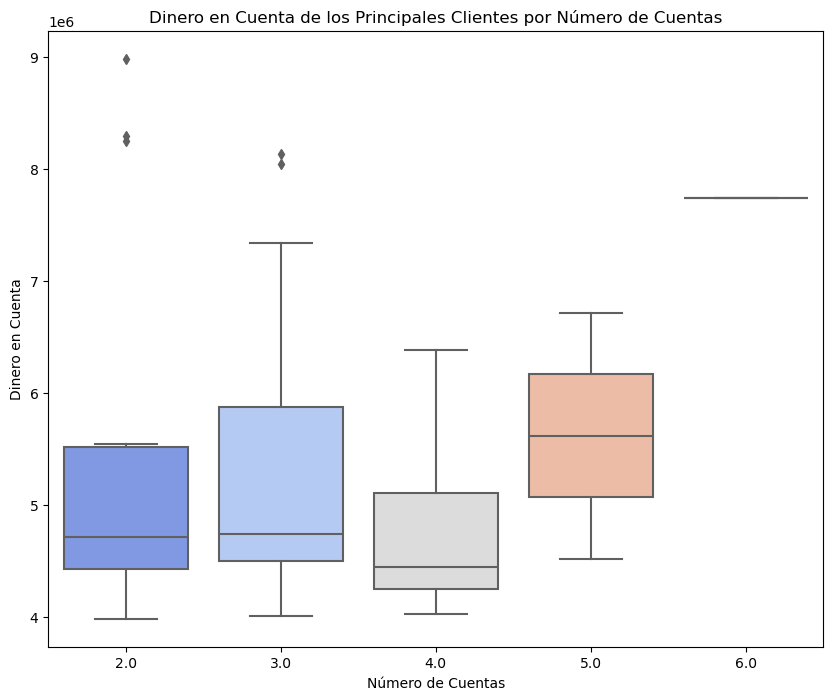

In [259]:
#vemos la relación entre dinero en cuenta y número de cuentas sin valores outliers

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.boxplot(x=df_clientes_principales['num_accounts'], y=df_clientes_principales['total_balance'], palette='coolwarm')
plt.title('Dinero en Cuenta de los Principales Clientes por Número de Cuentas')
plt.xlabel('Número de Cuentas')
plt.ylabel('Dinero en Cuenta')
plt.show()

In [260]:
#calculamos la tabla de contigencia entre dinero en cuenta y número de cuentas

crosstab_1 = pd.crosstab(df_clientes_principales['total_balance'], df_clientes_principales['num_accounts'])

In [261]:
#realizamos el chi-square test para ver si los valores dinero en cuenta y número de cuentas están relacionados

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_1)

chi2_statistic, chi2_p_value

(192.0, 0.4054876130845488)

In [262]:
#según chi-square test no hay suficiente evidencia para decir que hay una asociación significativa entre las variables
#no calculamos la cramer's v effect size porque chi-square indica que no hay relación

In [263]:
#hacemos lo mismo con los siguientes valores a priori correlacionados: edad y dinero en la cuenta

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



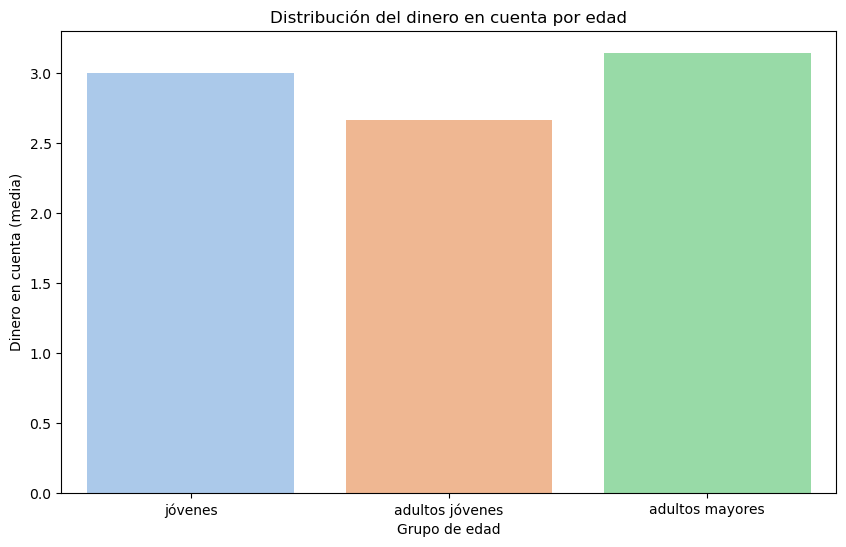

In [264]:
# Crear el gráfico de violín del dinero en cuenta por edad

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='age_grouped', y='num_accounts', data=df_clientes_principales, palette='pastel', errorbar=None)
plt.title('Distribución del dinero en cuenta por edad')
plt.xlabel('Grupo de edad')
plt.ylabel('Dinero en cuenta (media)')
plt.show()

In [265]:
df_clientes_principales['total_balance_grouped'] = pd.cut(df_clientes_principales['total_balance'], bins=3, labels=['Bajo', 'Medio', 'Alto'])

In [266]:
import plotly.express as px

orden = ['Bajo', 'Medio', 'Alto']


fig = px.box(df_clientes_principales, x="total_balance_grouped", y="login_month", color="gender")
fig.update_layout(xaxis=dict(categoryorder='array', categoryarray=orden))
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

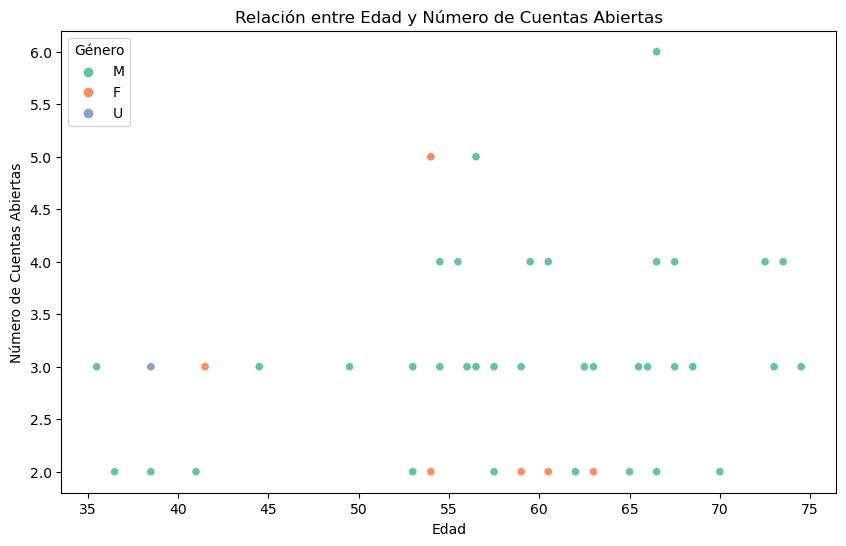

In [267]:
#creamos un gráfico de dispersión de edad, género y número de cuentas abiertas

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='num_accounts', data=df_clientes_principales, hue='gender', palette='Set2')
plt.title('Relación entre Edad y Número de Cuentas Abiertas')
plt.xlabel('Edad')
plt.ylabel('Número de Cuentas Abiertas')
plt.legend(title='Género', loc='upper left')
plt.show()

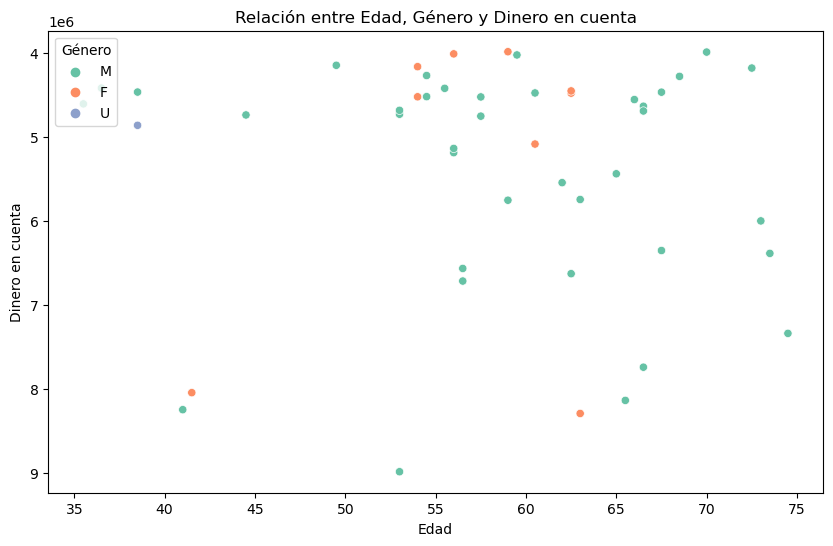

In [268]:
#creamos un gráfico de dispersión de edad, género y dinero en cuenta

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='total_balance', data=df_clientes_principales, hue='gender', palette='Set2')
plt.title('Relación entre Edad, Género y Dinero en cuenta')
plt.xlabel('Edad')
plt.ylabel('Dinero en cuenta')
plt.legend(title='Género', loc='upper left')
plt.gca().invert_yaxis()
plt.show()

In [284]:
#calculamos la matriz de correlación para crear un mapa de calor que muestre la relación entre todas las variables

#convertimos variables categóricas en variables dummy
df_dummies_1 = pd.get_dummies(df_final_web_data['process_step'])
df_dummies_1

#añadimos las nuevas columnas al df principal

df_final_web_data_dummy = pd.concat([df_final_web_data, df_dummies_1], axis=1)


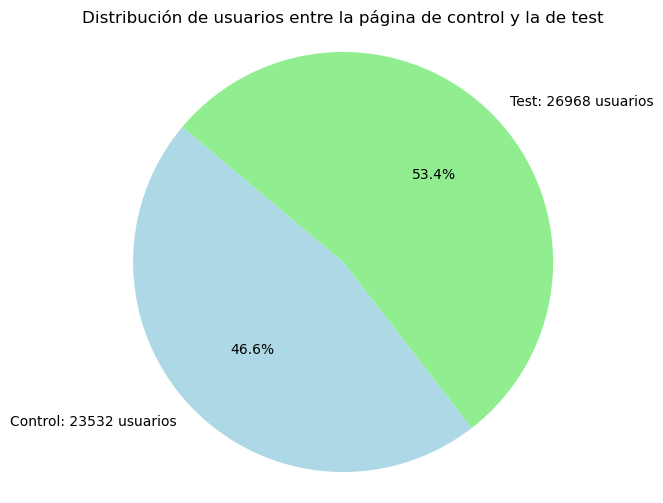

In [290]:
import matplotlib.pyplot as plt

# Contar el número de usuarios que han visto la página de control y la de test
control_users = df_exp[df_exp['Variation'] == 'Control']['client_id'].nunique()
test_users = df_exp[df_exp['Variation'] == 'Test']['client_id'].nunique()

# Crear una lista con los nombres de las variantes y otra lista con los tamaños correspondientes
variantes = ['Control', 'Test']
tamaños = [control_users, test_users]

# Crear el gráfico circular
plt.figure(figsize=(8, 6))
patches, texts, _ = plt.pie(tamaños, labels=variantes, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen'])
plt.title('Distribución de usuarios entre la página de control y la de test')
plt.axis('equal')  # Para que el gráfico sea un círculo en lugar de una elipse

# Agregar anotaciones con el número exacto de usuarios al pasar el cursor sobre el gráfico
for i, texto in enumerate(texts):
    texto.set_text(f"{variantes[i]}: {tamaños[i]} usuarios")

plt.show()

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



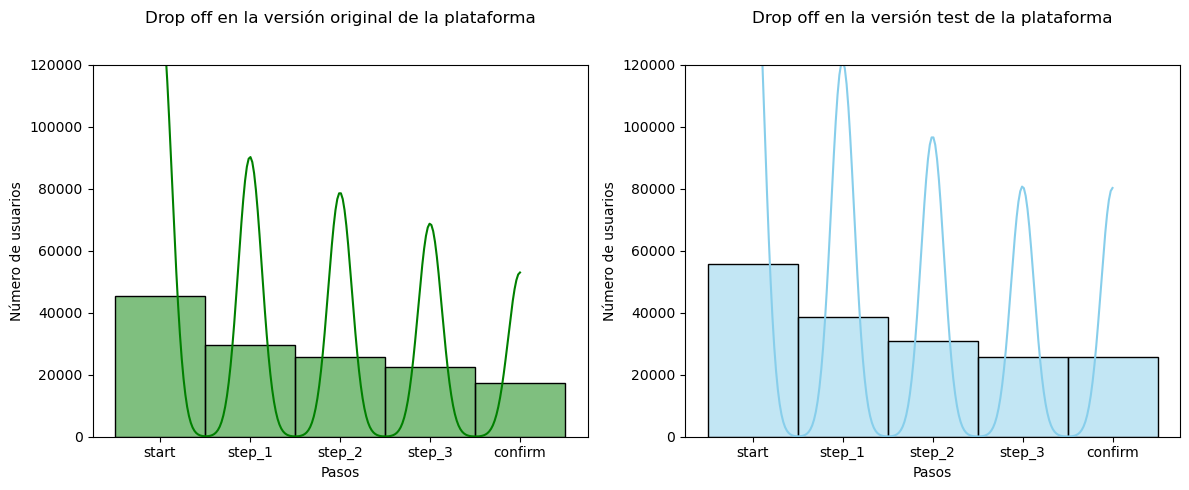

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Creamos el dataframe solo con los usuarios que han realizado el test
df_test = df_final_web_data_dummy.merge(df_exp[df_exp['Variation'] == 'Test'], how='inner', on='client_id')

# Creamos el dataframe solo con los usuarios que han realizado la versión original
df_control = df_final_web_data_dummy.merge(df_exp[df_exp['Variation'] == 'Control'], how='inner', on='client_id')

# Ordenamos los pasos para que se muestren en el orden natural
orden = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Convertimos la columna process_step a tipo categórico con el orden deseado
df_test['process_step'] = pd.Categorical(df_test['process_step'], categories=orden, ordered=True)

# Convertimos la columna process_step a tipo categórico con el orden deseado
df_control['process_step'] = pd.Categorical(df_control['process_step'], categories=orden, ordered=True)

# Creamos los histogramas ordenados
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

# Graficamos el avance de los usuarios en la versión original de la plataforma
sns.histplot(df_control['process_step'], bins=20, kde=True, color='green', ax=axes[0])
axes[0].set_title('Drop off en la versión original de la plataforma', pad=30)  # Ajustamos la distancia entre el título y el gráfico
axes[0].set_xlabel('Pasos')
axes[0].set_ylabel('Número de usuarios')
axes[0].set_ylim(0, 120000)  # Establecemos el límite superior del eje y

# Graficamos el avance de los usuarios que hicieron el test en la plataforma
sns.histplot(df_test['process_step'], bins=20, kde=True, color='skyblue', ax=axes[1])
axes[1].set_title('Drop off en la versión test de la plataforma', pad=30)  # Ajustamos la distancia entre el título y el gráfico
axes[1].set_xlabel('Pasos')
axes[1].set_ylabel('Número de usuarios')
axes[1].set_ylim(0, 120000)  # Establecemos el límite superior del eje y

plt.tight_layout()  # Ajustamos el diseño para evitar solapamientos
plt.show()

In [292]:
#eliminamos los datos nulos y con ellos se eliminan 20109 filas
df_exp = df_exp.dropna(subset =["Variation"])

#agrupamos el df_final_web_data con df_exp para añadir si el cliente ha visto la plataforma original o el test

df_transacciones = df_final_web_data_dummy.merge(df_exp, how='left', left_on='client_id', right_on='client_id').dropna(subset='Variation')

In [293]:
#agrupamos el df_final_web_data con df_exp para añadir si el cliente ha visto la plataforma original o el test

df_transacciones = df_final_web_data_dummy.merge(df_exp, how='left', left_on='client_id', right_on='client_id').dropna(subset='Variation')

In [294]:
#ordenamos los valores del df por cliente id, visita id y
df_transacciones = df_transacciones.sort_values(by=['client_id', 'visit_id', 'date_time'])

In [295]:
#creamos una nueva columna en la que añadimos la fecha en la que el usuario realizó el paso anterior

df_transacciones['time_last_step'] = df_transacciones.groupby(by=['client_id', 'visit_id'])['date_time'].shift(1)

In [296]:
#creamos una nueva columna para añadir el paso anterior al actual

df_transacciones['last_step'] = df_transacciones.groupby(by=['client_id', 'visit_id'])['process_step'].shift(1)

In [297]:
#restamos la fecha del paso anterior a la del actual para ver cuánto ha tardado en pasar de un paso a otro

df_transacciones['time_difference'] = df_transacciones['date_time'] - df_transacciones['time_last_step']

In [298]:
#agregamos una nueva columna en la que incluimos el nombre del paso anterior y el paso actual

df_transacciones['steps'] = df_transacciones['process_step'].astype(str) + '_' + df_transacciones['last_step'].astype(str)

In [299]:
#eliminamos las filas que tienen valores nulos en time_difference, ya que son el primer paso realizado por el usuario en cada visita

df_transacciones_para_grafico = df_transacciones.dropna(subset='time_difference')

In [300]:
#creamos un nuevo df para el gráfico en el que agrupamos los pasos, la variación (si ha realizado el test o no) y el tiempo que han tardado los usuarios en ir de un paso a otro

df_transacciones_por_tiempo = df_transacciones_para_grafico.groupby(by=['steps', 'Variation'])['time_difference'].mean().reset_index()


In [301]:
#realizamos un gráfico de barras agrupadas para comprobar de manera visual cuánto tiempo tardan los usuarios en ir de un paso a otro

import plotly.express as px

#ordenamos los pasos según el orden natural

orden = ['start_start', 'start_step_1', 'start_step_2', 'start_step_3', 'start_confirm', 'step_1_start', 'step_1_step_1', 'step_1_step_2', 'step_1_step_3', 'step_1_confirm',\
        'step_2_start', 'step_2_step_1', 'step_2_step_2', 'step_2_step_3', 'step_2_confirm', 'step_3_start', 'step_3_step_1', 'step_3_step_2', 'step_3_step_3', 'step_3_confirm',\
        'confirm_start', 'confirm_step_1', 'confirm_step_2', 'confirm_step_3', 'confirm_confirm']

#creamos el gráfico

fig = px.bar(df_transacciones_por_tiempo, x="steps", y="time_difference", color="Variation", barmode='group')

#lo ordenamos según el listado de orden creado previamente

fig.update_layout(xaxis=dict(categoryorder='array', categoryarray=orden))

#modificamos el título y etiquetas del gráfico

fig.update_layout(title="Tiempo promedio que tardan los usuarios en ir de un paso a otro según variación", xaxis_title='pasos', yaxis_title='tiempo promedio')

#mostramos el gráfico

fig.show()

In [302]:
#indicamos el orden en el que queremos que se realice el loop

orden = ["start", "step_1", "step_2", "step_3", "confirm"]

#creamos una nueva variable para cada tipo de variación
variation = ['Test', 'Control']

#creamos un nuevo dataframe
df_stats = pd.DataFrame(columns=orden, index=variation)

#recorremos cada variación
for variation_i in variation:
    #inicializamos el orden en 0
    i=0
    #recorremos cada paso
    for step_i in orden[-4:]:
        #para cada variación
        df_temp = df_transacciones[df_transacciones['Variation'] == variation_i]
        #calculamos la tasa de conversión de cada paso, es decir, de usuarios que pasan al siguiente paso desde el inmediatamente previo
        df_stats.loc[variation_i, orden[i]] = (df_temp[df_temp['steps'] == orden[i] + '_' + step_i]['visit_id'].count() / df_temp.groupby(by = 'process_step')['visit_id'].count()[orden[i]]) * 100
        #terminamos el loop
        i = i + 1        

In [303]:
#eliminamos la columna de confirm que tiene valores nulos
df_stats.dropna(axis=1, inplace=True)

#mostramos el dataframe
df_stats

,start,step_1,step_2,step_3
Test,11.482258,8.126002,7.385352,0.0854
Control,5.486999,4.704847,9.17239,0.448829


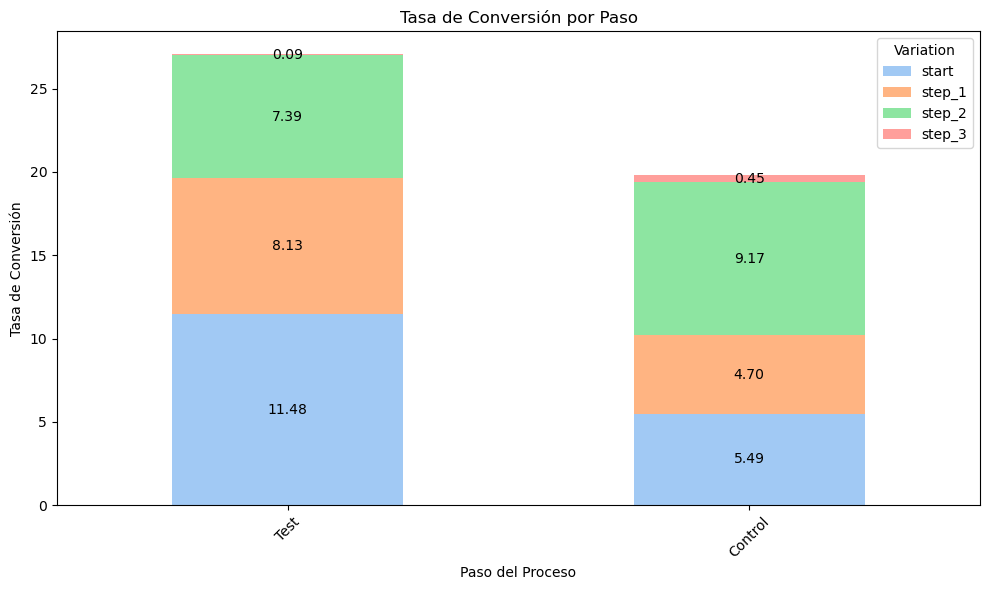

In [304]:
#creamos el gráfico de la tasa de conversión para cada paso

import matplotlib.pyplot as plt
import seaborn as sns

# Definimos una paleta de colores suave
sns.set_palette("pastel")

# Creamos el gráfico
ax = df_stats.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Tasa de Conversión por Paso')
plt.xlabel('Paso del Proceso')
plt.ylabel('Tasa de Conversión')
plt.xticks(rotation=45)
plt.legend(title='Variation')

# Agregamos etiquetas de texto para mostrar las tasas de conversión exactas en cada barra
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()
plt.show()

In [305]:
import pandas as pd
import matplotlib.pyplot as plt

In [306]:
# Unimos los dataframes en uno solo utilizando la columna 'client_id' como clave
df_merged_para_tasa_de_conversion_total = pd.merge(df_final_web_data, df_exp, on='client_id')

In [307]:
# Calculamos el número total de usuarios que completaron el proceso (llegaron al paso 'confirm')
confirm_total_por_variacion = df_merged_para_tasa_de_conversion_total[df_merged_para_tasa_de_conversion_total['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique()

In [308]:
# Calculamos el número total de usuarios que comenzaron el proceso (iniciaron el paso 'start')

start_total_por_variacion = df_merged_para_tasa_de_conversion_total[df_merged_para_tasa_de_conversion_total['process_step'] == 'start'].groupby('Variation')['client_id'].nunique()

In [309]:
# Calculamos la tasa de conversión total por variación
conversion_rate_total = confirm_total_por_variacion / start_total_por_variacion

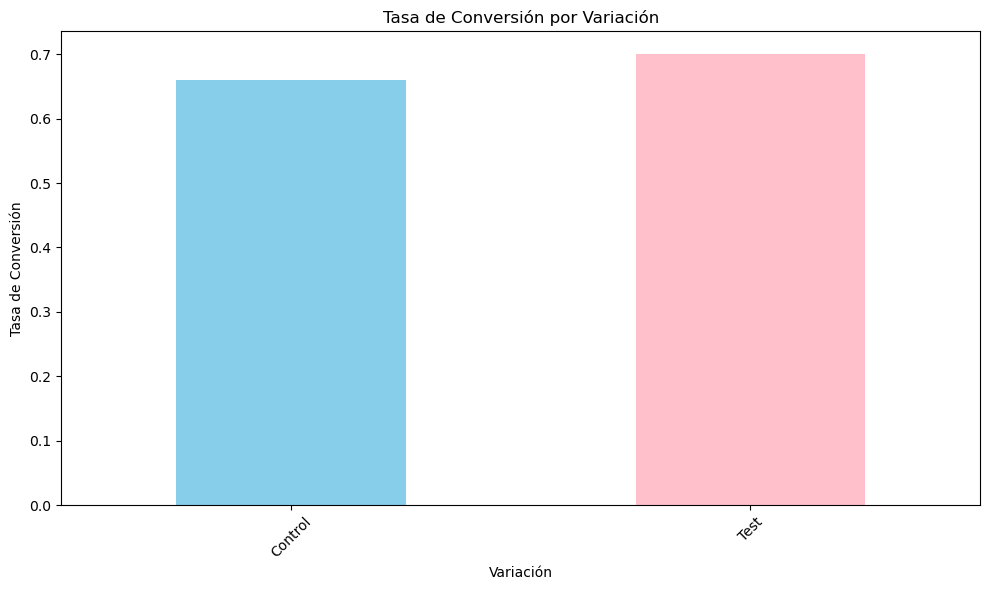

In [310]:
import matplotlib.pyplot as plt

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conversion_rate_total.plot(kind='bar', color=['skyblue', 'pink'])

# Configurar el título y etiquetas
plt.title('Tasa de Conversión por Variación')
plt.xlabel('Variación')
plt.ylabel('Tasa de Conversión')
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_merged_para_tasa_de_abandono = pd.merge(df_final_web_data, df_exp, on='client_id')

In [312]:
df_merged_para_tasa_de_abandono

,client_id,visitor_id,visit_id,process_step,date_time,Variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
317230,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test
317231,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control
317232,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control
317233,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control


In [313]:
# Calcular el número de usuarios que comenzaron el proceso para cada variación
variacion_total = df_merged_para_tasa_de_abandono.groupby('Variation')['client_id'].nunique()

In [314]:
# Calculamos el número de usuarios que completaron el proceso para cada variación
proceso_completado = df_merged_para_tasa_de_abandono[df_merged_para_tasa_de_abandono['process_step'] == 'confirm'].groupby('Variation')['client_id'].nunique()

In [315]:
# Calculamos la tasa de abandono total para cada variación

ratio_de_abandono = 1 - (proceso_completado / variacion_total)

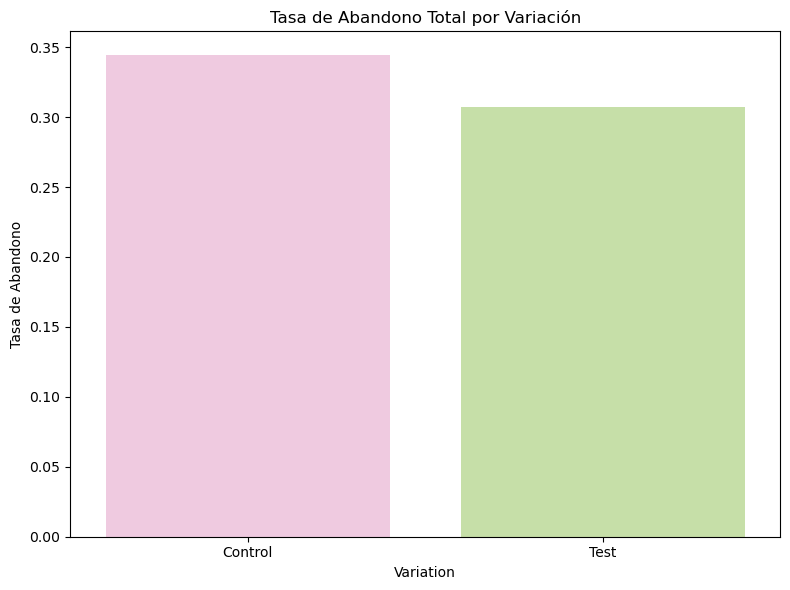

In [316]:
# Graficar la tasa de abandono total por variación
plt.figure(figsize=(8, 6))
sns.barplot(x=ratio_de_abandono.index, y=ratio_de_abandono.values, palette='PiYG')
plt.title('Tasa de Abandono Total por Variación')
plt.xlabel('Variation')
plt.ylabel('Tasa de Abandono')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [317]:
#agrupamos el dataframe por variación y tiempo entrada y de salida de cada usuario por id de visita

df_tiempo_de_permanencia = df_transacciones.groupby(by=['Variation', 'visit_id'])['date_time'].agg(['max', 'min']).reset_index()

In [318]:
#agregamos una columna con el tiempo total por sesión de cada id de visita

df_tiempo_de_permanencia['difference_time'] = df_tiempo_de_permanencia['max'] - df_tiempo_de_permanencia['min']

In [319]:
#transformamos el tiempo a segundos

df_tiempo_de_permanencia['difference_time_in_seconds'] = df_tiempo_de_permanencia['difference_time'].dt.total_seconds()

In [320]:
#calculamos la media de tiempo de permanencia total por cada variación

df_tiempo_de_permanencia_total = df_tiempo_de_permanencia.groupby('Variation')['difference_time_in_seconds'].agg('mean')

In [321]:
df_tiempo_de_permanencia_total

Variation
Control    281.601292
Test       316.777844
Name: difference_time_in_seconds, dtype: float64

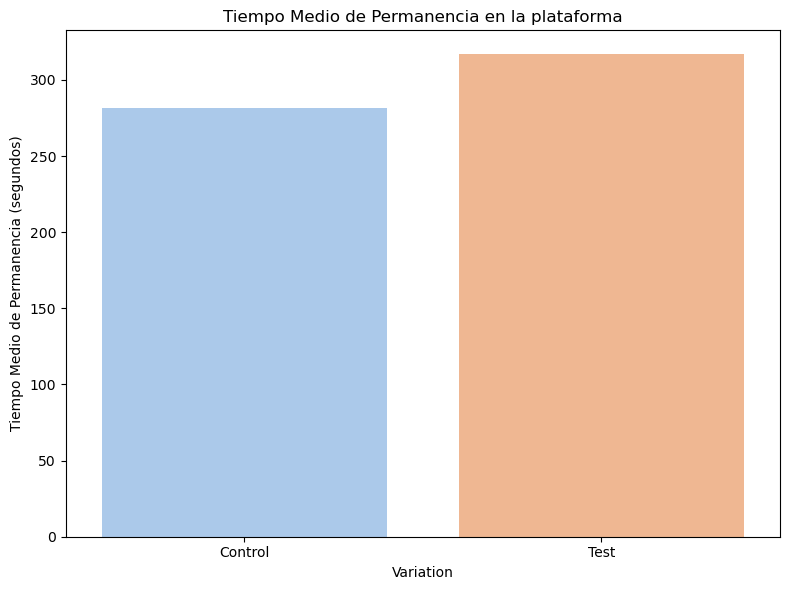

In [322]:
# Graficamos el tiempo medio de permanencia en el sitio web por variación

df_tiempo_de_permanencia_total.plot(kind='bar', figsize=(8, 6))
sns.barplot(x=df_tiempo_de_permanencia_total.index, y=df_tiempo_de_permanencia_total.values, palette='pastel')
plt.title('Tiempo Medio de Permanencia en la plataforma')
plt.xlabel('Variation')
plt.ylabel('Tiempo Medio de Permanencia (segundos)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [323]:
#calculamos cuántos usuarios han estado menos de 10 segundos en la página

tiempo_permanencia_menor_10_secs = (df_tiempo_de_permanencia['difference_time_in_seconds'] <= 10).groupby(df_tiempo_de_permanencia['Variation']).sum()

In [324]:
tiempo_permanencia_menor_10_secs

Variation
Control    6858
Test       6575
Name: difference_time_in_seconds, dtype: int64

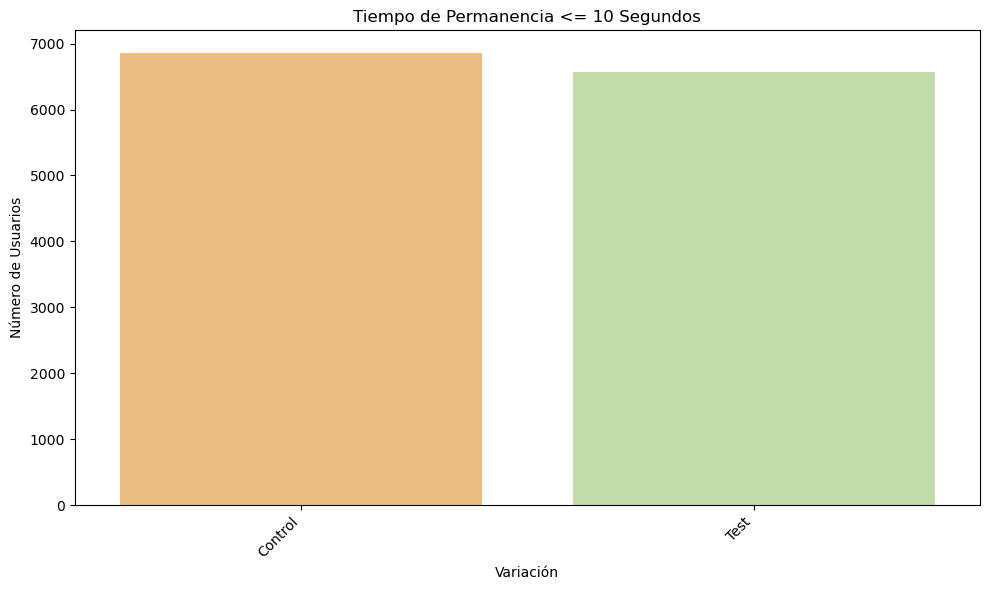

In [325]:
# Crear el gráfico
plt.figure(figsize=(10, 6))
tiempo_permanencia_menor_10_secs.plot(kind='bar')
sns.barplot(x=tiempo_permanencia_menor_10_secs.index, y=tiempo_permanencia_menor_10_secs.values, palette='Spectral')
plt.title('Tiempo de Permanencia <= 10 Segundos')
plt.xlabel('Variación')
plt.ylabel('Número de Usuarios')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [326]:
#hipótesis: tiempo promedio de los usuarios del Test > que el tiempo promedio de los usuarios de Control
#H₀: tiempo promedio Test = tiempo promedio Control
#H¹: tiempo promedio Test > tiempo promedio Control

In [327]:
import scipy.stats as st

In [328]:
df_tiempo_de_permanencia_control = df_tiempo_de_permanencia[(df_tiempo_de_permanencia['Variation'] == 'Control')]['difference_time_in_seconds']

In [329]:
df_tiempo_de_permanencia_test = df_tiempo_de_permanencia[(df_tiempo_de_permanencia['Variation'] == 'Test')]['difference_time_in_seconds']

In [330]:
alpha = 0.05

In [331]:
t_stat, p_value = st.ttest_ind(df_tiempo_de_permanencia_test, df_tiempo_de_permanencia_control, equal_var=False, alternative="greater")

In [332]:
t_stat, p_value

(8.258106732507365, 7.528994000448028e-17)

In [333]:
if p_value > alpha:
    print('No hemos sido capaces de rechazar la hipótesis nula')
else:
    print('Rechazamos la hipótesis nula')

Rechazamos la hipótesis nula


In [334]:
#hipótesis: conversión del Test > conversión de Control
#H₀: converión del Test = conversión de Control
#H¹: conversión del Test > conversión de Control

In [335]:
conversion_rate_total = confirm_total_por_variacion / start_total_por_variacion

In [336]:
conversion_rate_total

Variation
Control    0.659657
Test       0.700439
Name: client_id, dtype: float64

In [337]:
df_merged_para_tasa_de_conversion_total

,client_id,visitor_id,visit_id,process_step,date_time,Variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
317230,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test
317231,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control
317232,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control
317233,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control


In [338]:
df_confirm_visit_id = df_merged_para_tasa_de_conversion_total[df_merged_para_tasa_de_conversion_total['process_step'] == 'confirm'].groupby('visit_id')['client_id'].nunique().reset_index().rename(columns={'client_id' : 'confirm_binary'})

In [339]:
df_visit_id = df_merged_para_tasa_de_conversion_total[df_merged_para_tasa_de_conversion_total['process_step'] == 'start'][['visit_id', 'Variation']]

In [340]:
df_visit_id

,visit_id,Variation
7,781255054_21935453173_531117,Test
12,960651974_70596002104_312201,Test
19,949661017_22392791362_127391,Control
28,132494692_73738638511_70823,Test
29,116640698_27328181095_188045,Control
...,...,...
317224,773565250_67577573147_389841,Control
317225,412278907_8949064401_171038,Test
317230,528720790_71583064618_169151,Test
317231,562606085_36368381773_92090,Control


In [341]:
df_conversion = df_visit_id.merge(df_confirm_visit_id, how='left', on='visit_id')

In [342]:
df_conversion

,visit_id,Variation,confirm_binary
0,781255054_21935453173_531117,Test,NaN
1,960651974_70596002104_312201,Test,1.0
2,949661017_22392791362_127391,Control,1.0
3,132494692_73738638511_70823,Test,1.0
4,116640698_27328181095_188045,Control,NaN
...,...,...,...
101148,773565250_67577573147_389841,Control,1.0
101149,412278907_8949064401_171038,Test,NaN
101150,528720790_71583064618_169151,Test,1.0
101151,562606085_36368381773_92090,Control,NaN


In [343]:
df_conversion_test = df_conversion[df_conversion['Variation'] == 'Test'].fillna(0)
df_conversion_control = df_conversion[df_conversion['Variation'] == 'Control'].fillna(0)


In [344]:
#hipótesis: conversión del Test > conversión de Control
#H₀: converión del Test = conversión de Control
#H¹: conversión del Test > conversión de Control

In [345]:
t_stat, p_value = st.ttest_ind(df_conversion_test['confirm_binary'], df_conversion_control['confirm_binary'], equal_var=False, alternative="greater")

In [346]:
p_value

7.916329443880297e-29

In [347]:
if p_value < alpha:
    print('Hay suficiente evidencia como para descartar la hipótesis nula')
    print('La tasa de conversión de la nueva plataforma es mayor que la original')
else:
    print('No hay suficiente evidencia como para descartar la hipótesis nula')

Hay suficiente evidencia como para descartar la hipótesis nula
La tasa de conversión de la nueva plataforma es mayor que la original


In [348]:
#hipótesis: conversión del Test < conversión de Control
#H₀: converión del Test = conversión de Control
#H¹: conversión del Test < conversión de Control

In [349]:
t_stat, p_value = st.ttest_ind(df_conversion_test['confirm_binary'], df_conversion_control['confirm_binary'], equal_var=False, alternative="less")

In [350]:
if p_value < alpha:
    print('Hay suficiente evidencia como para descartar la hipótesis nula')
    print('La tasa de conversión de la nueva plataforma es mayor que la original')
else:
    print('No hay suficiente evidencia como para descartar la hipótesis nula')

No hay suficiente evidencia como para descartar la hipótesis nula


In [351]:
#comprobamos que la distribución del tiempo de permanencia en el control y el test es normal 

In [352]:
df_tiempo_de_permanencia = df_tiempo_de_permanencia[['Variation', 'difference_time_in_seconds']]

In [494]:
df_tiempo_de_permanencia_control = df_tiempo_de_permanencia[df_tiempo_de_permanencia['Variation'] == 'Control']
df_tiempo_de_permanencia_test = df_tiempo_de_permanencia[df_tiempo_de_permanencia['Variation'] == 'Test']

In [390]:
df_tiempo_de_permanencia_test

,Variation,difference_time_in_seconds
32189,Test,52.0
32190,Test,242.0
32191,Test,180.0
32192,Test,95.0
32193,Test,1017.0
...,...,...
69320,Test,1709.0
69321,Test,139.0
69322,Test,728.0
69323,Test,154.0


In [391]:
#comprobamos la distribución del tiempo de permanencia en la versión de Control con el QQ plot

In [392]:
from scipy import stats

((array([-4.09037909, -3.87981107, -3.76481872, ...,  3.76481872,
          3.87981107,  4.09037909]),
  array([    0.,     0.,     0., ..., 17072., 22895., 41965.])),
 (346.45147438288956, 281.60129236695775, 0.6522660123387142))

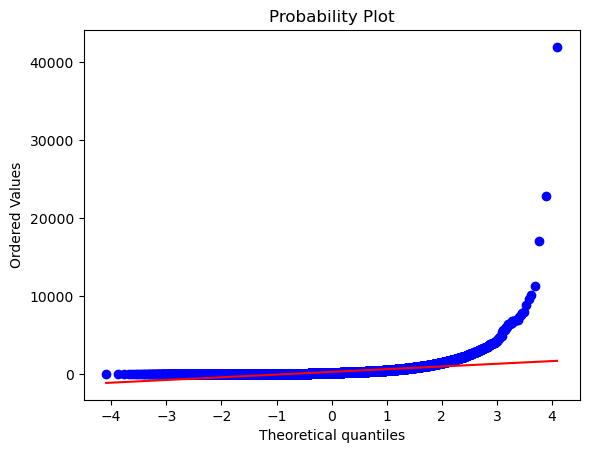

In [393]:
stats.probplot(df_tiempo_de_permanencia_control['difference_time_in_seconds'], plot=plt)

In [358]:
#gráficamente vemos que no hay una distribución normal para la versión de control, ya que la cola derecha está muy elejada de eje principal

In [359]:
#ahora comprobamos lo mismo con el K-S test

In [543]:
standardized_tiempo_de_permanencia_control = ((df_tiempo_de_permanencia_control['difference_time_in_seconds'] - df_tiempo_de_permanencia_control['difference_time_in_seconds']\
                                              .mean())/df_tiempo_de_permanencia_control['difference_time_in_seconds'].std())

ks_test_statistic, ks_p_value = stats.kstest(standardized_tiempo_de_permanencia_control, 'norm')

In [396]:
ks_p_value

0.0

In [397]:
if ks_p_value < 0.05:
    print('La distribución de tiempo de permanencia en la versión de Control es diferente a una distribución normal')
else:
    print('La distribución de tiempo de permanencia en la versión de Control no es significativamente diferente a la normal')

La distribución de tiempo de permanencia en la versión de Control es diferente a una distribución normal


In [363]:
#ahora lo comprobamos con Shapiro test

In [398]:
shapiro_test_statistic, shapiro_p_value = stats.shapiro(df_tiempo_de_permanencia_control['difference_time_in_seconds'])

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32189.



In [400]:
shapiro_p_value

1.6619791426193292e-133

In [401]:
if shapiro_p_value < 0.05:
    print('La distribución de tiempo de permanencia en la versión de Control es diferente a una distribución normal')
else:
    print('La distribución de tiempo de permanencia en la versión de Control no es significativamente diferente a la normal')

La distribución de tiempo de permanencia en la versión de Control es diferente a una distribución normal


In [495]:
df_tiempo_de_permanencia_control = df_tiempo_de_permanencia_control[df_tiempo_de_permanencia_control['difference_time_in_seconds'] > 40]

In [488]:
df_tiempo_de_permanencia_control

,Variation,difference_time_in_seconds,difference_time_in_seconds_min_max,difference_time_in_seconds_min_max_s
1,Control,132.0,0.064050,-0.587365
2,Control,254.0,0.316116,0.143567
3,Control,354.0,0.522727,0.742690
8,Control,363.0,0.541322,0.796612
10,Control,341.0,0.495868,0.664804
...,...,...,...,...
32175,Control,218.0,0.241736,-0.072118
32176,Control,513.0,0.851240,1.695297
32179,Control,127.0,0.053719,-0.617321
32181,Control,117.0,0.033058,-0.677233


c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='difference_time_in_seconds', ylabel='Count'>

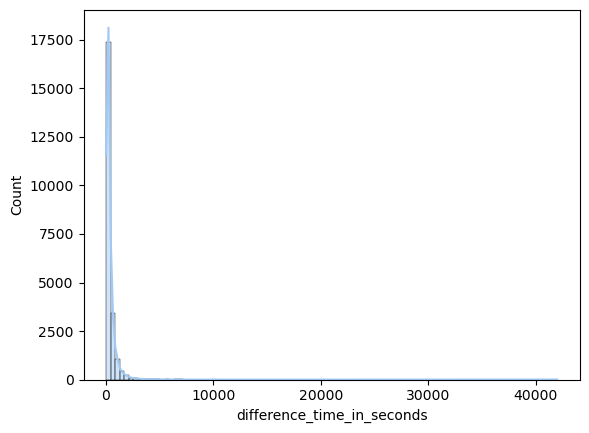

In [498]:
sns.histplot(df_tiempo_de_permanencia_control['difference_time_in_seconds'], kde=True, bins=100)

In [499]:
#después de realizar los tres tipos de tests comprobamos que la distribución no es normal, por lo que procedemos a transformarla

In [500]:

Q1 = df_tiempo_de_permanencia_control['difference_time_in_seconds'].quantile(0.25)
Q3 = df_tiempo_de_permanencia_control['difference_time_in_seconds'].quantile(0.75)
IQR = Q3 - Q1

In [501]:
#establecemos los límites de los outliers

limite_bajo = Q1 - 1 * IQR
limite_alto = Q3 + 1 * IQR

In [502]:
#identificamos los outliers y los filtramos de la tabla

df_tiempo_de_permanencia_control = df_tiempo_de_permanencia_control[(df_tiempo_de_permanencia_control['difference_time_in_seconds'] >= limite_bajo) & (df_tiempo_de_permanencia_control['difference_time_in_seconds'] <= limite_alto)]


c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='difference_time_in_seconds', ylabel='Count'>

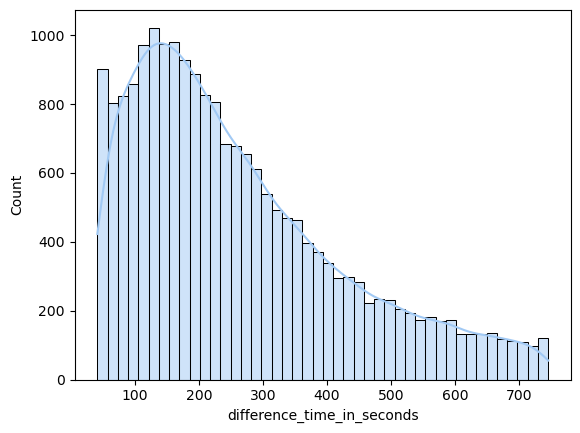

In [503]:
#representamos el tiempo de permanencia en un histograma

sns.histplot(df_tiempo_de_permanencia_control['difference_time_in_seconds'], kde=True)

In [504]:
#vemos que está muy escorado hacia la derecha, así que aplicamos la transformación logarítmica

In [505]:
import numpy as np

In [506]:
log_transformed_tiempo_de_permanencia_control = np.log1p(df_tiempo_de_permanencia_control['difference_time_in_seconds'])

In [507]:
standardized_tiempo_de_permanencia_control = (log_transformed_tiempo_de_permanencia_control - log_transformed_tiempo_de_permanencia_control.mean() / log_transformed_tiempo_de_permanencia_control.std())

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='difference_time_in_seconds', ylabel='Count'>

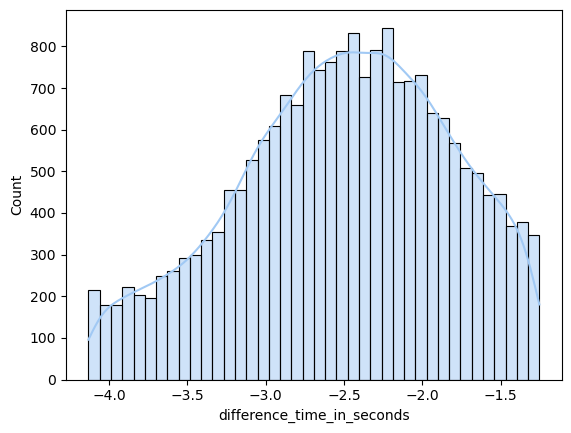

In [508]:
sns.histplot(standardized_tiempo_de_permanencia_control, kde=True)

In [509]:
standardized_tiempo_de_permanencia_control

1       -2.978108
2       -2.327193
3       -1.996339
5       -1.286432
8       -1.971303
           ...   
32181   -3.097772
32183   -3.379821
32184   -2.027815
32185   -1.344895
32186   -3.694070
Name: difference_time_in_seconds, Length: 20218, dtype: float64

In [510]:
shapiro_test_statistic, shapiro_p_value = stats.shapiro(standardized_tiempo_de_permanencia_control)

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20218.



In [511]:
shapiro_p_value

2.334675921785474e-44

In [512]:
#realizamos la prueba sklearn

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [513]:
scaler = MinMaxScaler()

In [514]:
df_tiempo_de_permanencia_control['difference_time_in_seconds_min_max'] = scaler.fit_transform(df_tiempo_de_permanencia_control[['difference_time_in_seconds']])

In [515]:
standardizer = StandardScaler()

In [516]:
df_tiempo_de_permanencia_control['difference_time_in_seconds_min_max_s'] = standardizer.fit_transform(df_tiempo_de_permanencia_control[['difference_time_in_seconds_min_max']])

In [517]:
stats.kstest(df_tiempo_de_permanencia_control['difference_time_in_seconds_min_max_s'], 'norm')

KstestResult(statistic=0.10135103244175553, pvalue=2.958295465741661e-181, statistic_location=-0.17132121925438665, statistic_sign=1)

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='difference_time_in_seconds_min_max', ylabel='Count'>

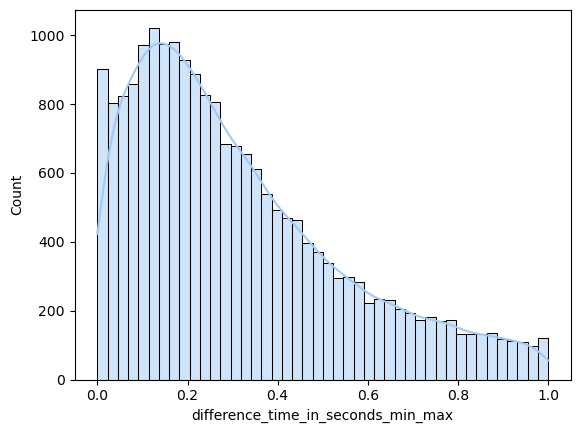

In [518]:
sns.histplot(df_tiempo_de_permanencia_control['difference_time_in_seconds_min_max'], kde=True)

In [523]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import johnsonsu, norm, kstest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ajustar la distribución de Johnson a los datos
params = johnsonsu.fit(df_tiempo_de_permanencia_control['difference_time_in_seconds'])

In [524]:

# Transformar los datos usando la distribución ajustada
df_tiempo_de_permanencia_control['difference_time_in_seconds_jonhsonsu'] = johnsonsu(*params).rvs(len(df_tiempo_de_permanencia_control))


In [526]:

# Estandarizar los datos transformados
df_tiempo_de_permanencia_control['difference_time_in_seconds_standarized'] = StandardScaler().fit_transform(df_tiempo_de_permanencia_control[['difference_time_in_seconds_jonhsonsu']])



In [527]:
# Realizar la prueba de Kolmogorov-Smirnov para normalidad en 'LotArea_Standardized'
ks_result = stats.kstest(df_tiempo_de_permanencia_control['difference_time_in_seconds_standarized'], 'norm')


c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



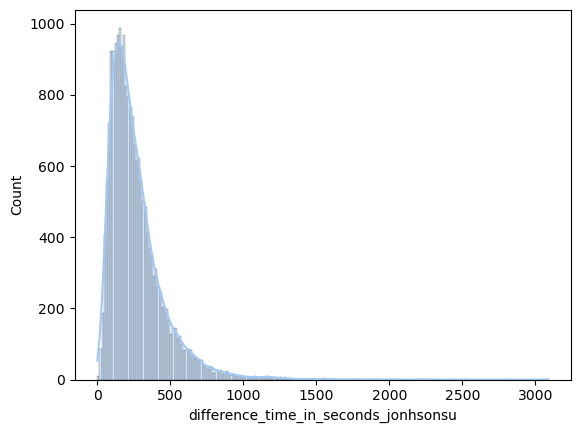

KstestResult(statistic=0.12062328603325079, pvalue=8.35746335496791e-257, statistic_location=0.15425032301035382, statistic_sign=1)


In [528]:

# Graficar la distribución de 'LotArea_JohnsonSU'
sns.histplot(df_tiempo_de_permanencia_control['difference_time_in_seconds_jonhsonsu'], kde=True)
plt.show()



In [537]:
Q1 = df_tiempo_de_permanencia_control['difference_time_in_seconds_jonhsonsu'].quantile(0.25)
Q3 = df_tiempo_de_permanencia_control['difference_time_in_seconds_jonhsonsu'].quantile(0.75)
IQR = Q3 - Q1
filter = (df_tiempo_de_permanencia_control['difference_time_in_seconds_jonhsonsu'] >= Q1 - 1.5 * IQR) & (df_tiempo_de_permanencia_control['difference_time_in_seconds_jonhsonsu'] <= Q3 + 1.5 * IQR)
df_tiempo_de_permanencia_control_sin_outliers_jonhsonsu = df_tiempo_de_permanencia_control.loc[filter]

In [540]:
df_tiempo_de_permanencia_control_sin_outliers_jonhsonsu ['difference_time_in_seconds_jonhsonsu_standarized'] = StandardScaler().fit_transform(df_tiempo_de_permanencia_control_sin_outliers_jonhsonsu[['difference_time_in_seconds_jonhsonsu']])


C:\Users\perez\AppData\Local\Temp\ipykernel_9300\1077348756.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [541]:
# Realizar la prueba de Kolmogorov-Smirnov para normalidad en 'LotArea_Standardized'
ks_result = stats.kstest(df_tiempo_de_permanencia_control_sin_outliers_jonhsonsu ['difference_time_in_seconds_jonhsonsu_standarized'], 'norm')

In [542]:
print(ks_result)

KstestResult(statistic=0.0833016179006173, pvalue=1.2875159720133396e-116, statistic_location=-0.18087092542702388, statistic_sign=1)


c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



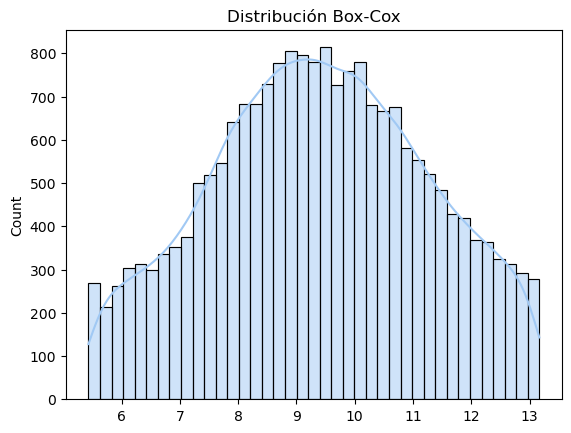

KS Test Statistic: [0.02248319], p-value: [2.60959033e-09]
Lambda used for Box-Cox transformation: 0.1887052317267239


In [530]:
from scipy.stats import boxcox

# Transformar los datos usando Box-Cox
boxcox_data, lmbda = boxcox(df_tiempo_de_permanencia_control['difference_time_in_seconds'] + 1)  # Se suma 1 para evitar log(0)

# Estandarizar los datos transformados
boxcox_data_standardized = StandardScaler().fit_transform(boxcox_data.reshape(-1, 1))

# Realizar la prueba de Kolmogorov-Smirnov para normalidad
ks_result_boxcox = kstest(boxcox_data_standardized, 'norm')

# Graficar la distribución de Box-Cox
sns.histplot(boxcox_data, kde=True)
plt.title("Distribución Box-Cox")
plt.show()

print(f'KS Test Statistic: {ks_result_boxcox.statistic}, p-value: {ks_result_boxcox.pvalue}')
print(f'Lambda used for Box-Cox transformation: {lmbda}')

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



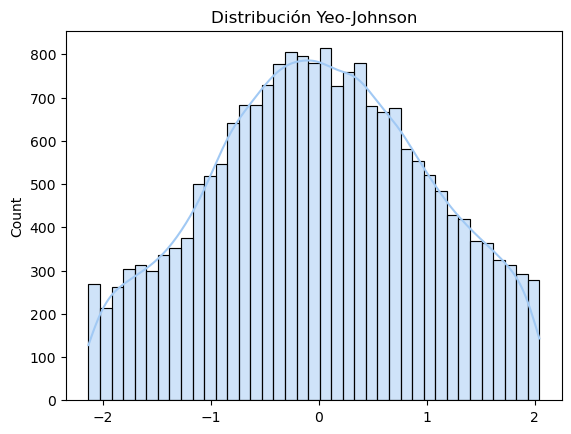

KS Test Statistic: 0.022483194052738353, p-value: 2.609592050838518e-09


In [531]:
from sklearn.preprocessing import PowerTransformer

# Aplicar la transformación de Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
yeojohnson_data = pt.fit_transform(df_tiempo_de_permanencia_control[['difference_time_in_seconds']])

# Realizar la prueba de Kolmogorov-Smirnov para normalidad
ks_result_yeojohnson = kstest(yeojohnson_data.flatten(), 'norm')

# Graficar la distribución de Yeo-Johnson
sns.histplot(yeojohnson_data.flatten(), kde=True)
plt.title("Distribución Yeo-Johnson")
plt.show()

print(f'KS Test Statistic: {ks_result_yeojohnson.statistic}, p-value: {ks_result_yeojohnson.pvalue}')

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



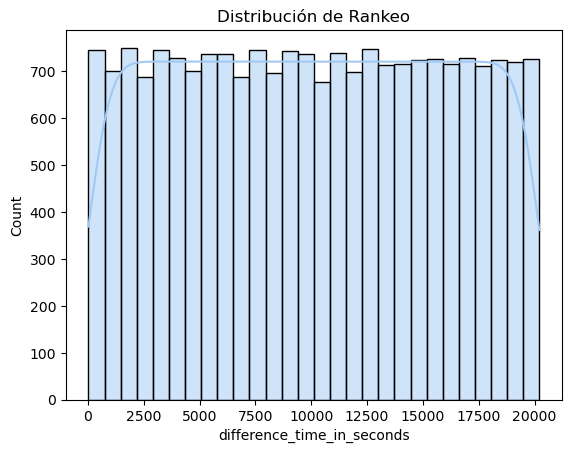

KS Test Statistic: 0.05884860054622876, p-value: 2.635007232077098e-61


In [536]:
# Transformación de Rankeo
ranked_data = df_tiempo_de_permanencia_control['difference_time_in_seconds'].rank()

# Estandarizar los datos transformados
ranked_data_standardized = StandardScaler().fit_transform(ranked_data.values.reshape(-1, 1))

# Realizar la prueba de Kolmogorov-Smirnov para normalidad
ks_result_ranked = kstest(ranked_data_standardized.flatten(), 'norm')

# Graficar la distribución de Rankeo
sns.histplot(ranked_data, kde=True)
plt.title("Distribución de Rankeo")
plt.show()

print(f'KS Test Statistic: {ks_result_ranked.statistic}, p-value: {ks_result_ranked.pvalue}')

In [544]:
standardized_tiempo_de_permanencia_test = ((df_tiempo_de_permanencia_test['difference_time_in_seconds'] - df_tiempo_de_permanencia_test['difference_time_in_seconds']\
                                              .mean())/df_tiempo_de_permanencia_test['difference_time_in_seconds'].std())

ks_test_statistic, ks_p_value = stats.kstest(standardized_tiempo_de_permanencia_test, 'norm')

In [545]:
ks_p_value

0.0

In [548]:
standardized_tiempo_de_permanencia_test

32189   -0.448579
32190   -0.126686
32191   -0.231725
32192   -0.375729
32193    1.186295
           ...   
69320    2.358660
69321   -0.301186
69322    0.696680
69323   -0.275773
69324   -0.336763
Name: difference_time_in_seconds, Length: 37136, dtype: float64

c:\Users\perez\anaconda3\envs\vanguard_project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



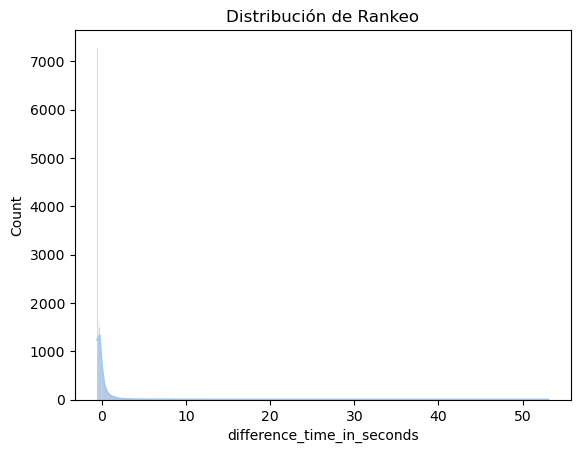

In [549]:
sns.histplot(standardized_tiempo_de_permanencia_test, kde=True)
plt.title("Distribución de Rankeo")
plt.show()

In [ ]:
#Conclusión: empleareamos algoritmos que permitan distribuciones no normales